In [92]:
import scipy as sp
import cv2
import numpy as np
import math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import pandas as pd

In [467]:
_img = cv2.imread('imgs/lin-calvin-3.jpg',3)
scale_percent = 100.0
h, w = len(_img), len(_img[0])
dim = (int(w * scale_percent / 100), int(h * scale_percent / 100))
dim

(1280, 720)

In [481]:
img = cv2.resize(_img, dim, interpolation = cv2.INTER_AREA)
img = _img[:, 550:, :]
h, w = len(img), len(img[0])
b, g, r = cv2.split(img)

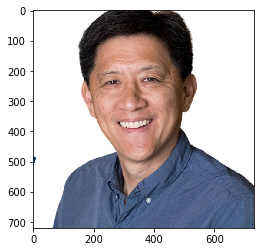

In [482]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [530]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=100000, contrastThreshold=0.0001, edgeThreshold=20, sigma=1.2)
# orb = cv2.ORB_create(nfeatures=10000, edgeThreshold = 2, patchSize=2)


In [531]:
kps, des = sift.detectAndCompute(img, None)
# kps, des = orb.detectAndCompute(img, None)

In [532]:
points = [[0, 0], [0, h-1], [w-1, 0], [w-1, h-1]]
for kp in kps:
    points.append([int(kp.pt[0]), int(kp.pt[1])])

In [533]:
tri = Delaunay(points)

def get_innerPt(a,b,c):
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    import numpy as np
    xs=np.array((x1,x2,x3),dtype=float)
    ys=np.array((y1,y2,y3),dtype=float)

    x_range=np.arange(np.min(xs),np.max(xs)+1)
    y_range=np.arange(np.min(ys),np.max(ys)+1)

    X,Y=np.meshgrid( x_range,y_range )
    xc=np.mean(xs)
    yc=np.mean(ys)

    triangle = np.ones(X.shape,dtype=bool)
    for i in range(3):
        ii=(i+1)%3
        if xs[i]==xs[ii]:
            include = X *(xc-xs[i])/abs(xc-xs[i]) > xs[i] *(xc-xs[i])/abs(xc-xs[i])
        else:
            poly=np.poly1d([(ys[ii]-ys[i])/(xs[ii]-xs[i]),ys[i]-xs[i]*(ys[ii]-ys[i])/(xs[ii]-xs[i])])
            include = Y *(yc-poly(xc))/abs(yc-poly(xc)) > poly(X) *(yc-poly(xc))/abs(yc-poly(xc))
        triangle*=include

    return X[triangle],Y[triangle]

def mode_of_color(innerPt, r, g, b):
    ar = []
    ag = []
    ab = []
    
    X, Y = innerPt
    for u, v in zip(X, Y):
        u = int(u) 
        v = int(v) 
        ar.append(r[v,u])
        ag.append(g[v,u])
        ab.append(b[v,u])
    ar = np.array(ar)
    ag = np.array(ag)
    ab = np.array(ab)
    return ar.mean(), ag.mean(), ab.mean()
colors = []
for ia, ib, ic in tri.vertices:
    ia, ib, ic = points[ia], points[ib], points[ic]
    innerPt = get_innerPt(ia, ib, ic) 
    color = mode_of_color(innerPt, r, g, b)
    colors.append(color)
    X, Y = innerPt
    for x, y in zip(X, Y):
        x = int(x)
        y = int(y)
    	img[y, x]  = color

    cv2.line(img, (ia[0], ia[1]) , (ib[0], ib[1]), color) 
    cv2.line(img, (ib[0], ib[1]) , (ic[0], ic[1]), color) 
    cv2.line(img, (ia[0], ia[1]) , (ic[0], ic[1]), color) 


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:55: RuntimeWarning: Mean of empty slice.


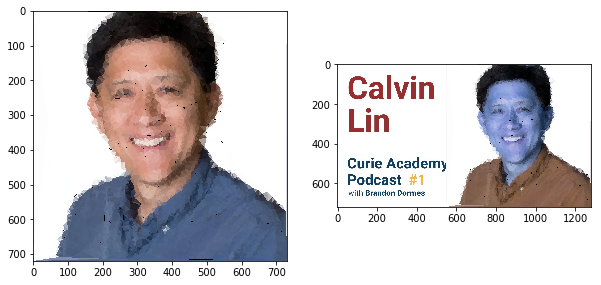

In [534]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img)
ax2.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
plt.show()

In [521]:
colors = np.array(colors)
colors.shape

(5532, 3)

In [537]:
f = open("out.txt", "w")
i = 0
for ia, ib, ic in tri.vertices:
    ia, ib, ic = points[ia], points[ib], points[ic]
    
    ia = dim - np.array(ia) - np.array([550, 0])  
    ib = dim - np.array(ib) - np.array([550, 0])  
    ic = dim - np.array(ic) - np.array([550, 0])  
    
    color = np.nan_to_num(colors[i])
    f.write("Calc.setExpression({{id: '{0}', fillOpacity: '1', latex: '\\\\operatorname{{polygon}}\\\\left(\\\\left({1},{2}\\\\right),\\\\ \\\\left({3},{4}\\\\right),\\\\ \\\\left({5},{6}\\\\right)\\\\right)', color: 'rgb({7}, {8}, {9})', lines: false}})\n".format(i, ia[0], ia[1], ib[0], ib[1], ic[0], ic[1], int(color[0]), int(color[1]), int(color[2])))
    i += 1

f.close()